In [36]:
import numpy as np
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator 
from sklearn.metrics import classification_report,confusion_matrix
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
!unzip /content/gdrive/MyDrive/chest-xray-pneumonia.zip

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0447-0001.jpeg  
  inflating:

In [23]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 128
def get_training_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [24]:
train = get_training_data('/content/chest_xray/chest_xray/train')
test = get_training_data('/content/chest_xray/test')
val = get_training_data('/content/chest_xray/chest_xray/val')

OpenCV(4.7.0) /io/opencv/modules/imgproc/src/resize.cpp:4062: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.7.0) /io/opencv/modules/imgproc/src/resize.cpp:4062: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



<ipython-input-23-8347ee4d15d3>:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


OpenCV(4.7.0) /io/opencv/modules/imgproc/src/resize.cpp:4062: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.7.0) /io/opencv/modules/imgproc/src/resize.cpp:4062: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



In [26]:
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)
    
for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

In [5]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rotation_range = 30,
        zoom_range=0.2,
        horizontal_flip=True)
val_Datagen = ImageDataGenerator(
        rescale = 1./255
)


train_generator = train_datagen.flow_from_directory(
        '/content/chest_xray/chest_xray/train',
        target_size=(128, 128),
        batch_size=128,
        class_mode='binary')
validation_generator = val_Datagen.flow_from_directory(
        '/content/chest_xray/chest_xray/val',
        target_size=(128, 128),
        batch_size=16,
        class_mode='binary')
test_generator = val_Datagen.flow_from_directory(
      '/content/chest_xray/chest_xray/test',
       target_size=(128, 128),
        batch_size=16,
        class_mode='binary')
                                      


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [6]:
base_model = tf.keras.applications.EfficientNetB2(input_shape=(128,128,3),
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = True

31790344/31790344 [==============================] - 1s 0us/step


In [7]:
model = tf.keras.models.Sequential()
model.add(base_model)
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.Dense(128 , activation='relu'))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(64 , activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(1 , activation='sigmoid'))

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb2 (Functional)  (None, 4, 4, 1408)       7768569   
                                                                 
 global_average_pooling2d (G  (None, 1408)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               180352    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                        

In [13]:
def setup_to_transfer_learn(model):
    for layer in model.layers[:-6]:    # since you added three new layers (which should not freeze)
        layer.trainable = False
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [14]:
setup_to_transfer_learn(model)

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb2 (Functional)  (None, 4, 4, 1408)       7768569   
                                                                 
 global_average_pooling2d (G  (None, 1408)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               180352    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                        

In [ ]:
base_learning_rate = 0.001
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=2)]
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [17]:
history = model.fit(train_generator,
                    epochs=29,
                    validation_data=validation_generator,
                    batch_size = 128)

Epoch 1/29
41/41 [==============================] - 112s 2s/step - loss: 0.5901 - accuracy: 0.7291 - val_loss: 0.8065 - val_accuracy: 0.5000
Epoch 2/29
41/41 [==============================] - 78s 2s/step - loss: 0.5794 - accuracy: 0.7429 - val_loss: 0.7783 - val_accuracy: 0.5000
Epoch 3/29
41/41 [==============================] - 77s 2s/step - loss: 0.5750 - accuracy: 0.7429 - val_loss: 0.7782 - val_accuracy: 0.5000
Epoch 4/29
41/41 [==============================] - 77s 2s/step - loss: 0.5779 - accuracy: 0.7429 - val_loss: 0.7691 - val_accuracy: 0.5000
Epoch 5/29
41/41 [==============================] - 79s 2s/step - loss: 0.5749 - accuracy: 0.7429 - val_loss: 0.8030 - val_accuracy: 0.5000
Epoch 6/29
41/41 [==============================] - 77s 2s/step - loss: 0.5773 - accuracy: 0.7429 - val_loss: 0.8026 - val_accuracy: 0.5000
Epoch 7/29
41/41 [==============================] - 77s 2s/step - loss: 0.5758 - accuracy: 0.7429 - val_loss: 0.7608 - val_accuracy: 0.5000
Epoch 8/29
41/41 [=

In [27]:
x_test_temp = np.asanyarray(x_test)[...,np.newaxis]
print(x_test_temp.shape)

(624, 128, 128, 1)


In [19]:
score = model.evaluate(test_generator)


39/39 [==============================] - 7s 172ms/step - loss: 0.6828 - accuracy: 0.6250


In [28]:
temp = np.asarray(x_test)[...,np.newaxis]
print((temp).shape)

(624, 128, 128, 1)


In [21]:
print("Train Loss: ", score[0])
print("Train Accuracy: ", score[1])

Train Loss:  0.6828129887580872
Train Accuracy:  0.625


In [22]:
predictions = model.predict(test_generator)


39/39 [==============================] - 9s 189ms/step


In [29]:
from sklearn.metrics import confusion_matrix
false_positive_rate2, true_positive_rate2 = confusion_matrix(y_test, np.round(predictions))

In [34]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
print( 'accuracy = ' , accuracy_score(y_test, np.round(predictions)))
print( 'recall = ' , recall_score(y_test, np.round(predictions)))
print( 'F1 = ' , f1_score(y_test, np.round(predictions)))

accuracy =  0.375
recall =  1.0
F1 =  0.5454545454545454


In [35]:
print(true_positive_rate2)
print(false_positive_rate2)

[  0 234]
[  0 390]


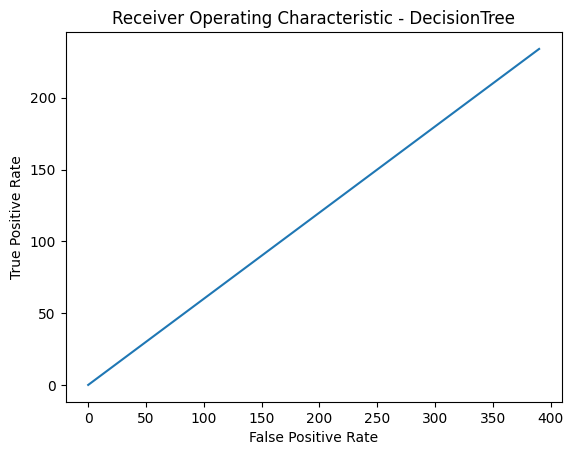

In [31]:
plt.title('Receiver Operating Characteristic - DecisionTree')
plt.plot(false_positive_rate2, true_positive_rate2)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

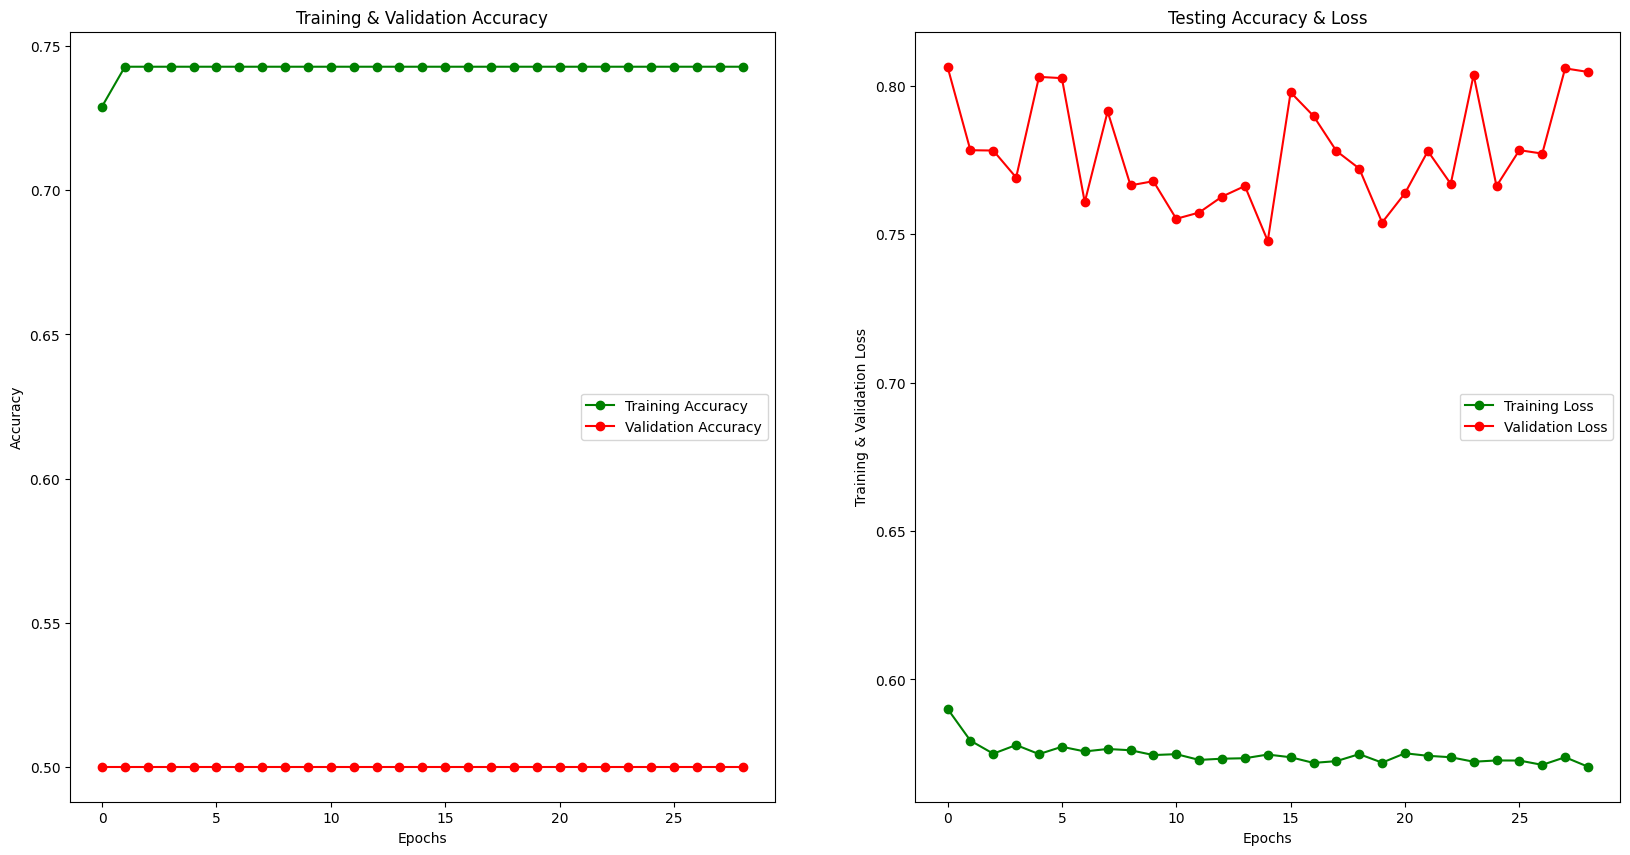

In [33]:
epochs = [i for i in range(29)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()